#Load Dataset

In [ ]:
!gdown --id 1mDSF-3Wl_3NR6yu6KXDtlrCtxWnAcADD

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1mDSF-3Wl_3NR6yu6KXDtlrCtxWnAcADD
From (redirected): https://drive.google.com/uc?id=1mDSF-3Wl_3NR6yu6KXDtlrCtxWnAcADD&confirm=t&uuid=0cf0ee78-36c7-4cf1-81b6-3572dbd9c80b
To: /content/Eye_Retina.zip
100% 771M/771M [00:13<00:00, 56.3MB/s]


In [ ]:
!unzip '/content/Eye_Retina.zip'

Archive:  /content/Eye_Retina.zip
   creating: Eye_Retina/cataract/
  inflating: Eye_Retina/cataract/_0_4015166.jpg  
  inflating: Eye_Retina/cataract/_1_5346540.jpg  
  inflating: Eye_Retina/cataract/_1_7703314.jpg  
  inflating: Eye_Retina/cataract/_10_3215668.jpg  
  inflating: Eye_Retina/cataract/_100_334408.jpg  
  inflating: Eye_Retina/cataract/_101_5139882.jpg  
  inflating: Eye_Retina/cataract/_101_709333.jpg  
  inflating: Eye_Retina/cataract/_102_1024926.jpg  
  inflating: Eye_Retina/cataract/_102_3990401.jpg  
  inflating: Eye_Retina/cataract/_103_5897328.jpg  
  inflating: Eye_Retina/cataract/_104_4607170.jpg  
  inflating: Eye_Retina/cataract/_105_5646774.jpg  
  inflating: Eye_Retina/cataract/_105_5956883.jpg  
  inflating: Eye_Retina/cataract/_106_5284713.jpg  
  inflating: Eye_Retina/cataract/_107_5060742.jpg  
  inflating: Eye_Retina/cataract/_108_750835.jpg  
  inflating: Eye_Retina/cataract/_108_8917257.jpg  
  inflating: Eye_Retina/cataract/_109_2006348.jpg  
  infl

In [ ]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Preprocess

In [ ]:
# Enable autotune
torch.backends.cudnn.benchmark = True

# Paths
data_dir = "/content/Eye_Retina"
batch_size = 32
patience = 5  # for early stopping

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

print(f"Total images: {total_size}")
print(f"Training images: {len(train_ds)}")
print(f"Validation images: {len(val_ds)}")
print(f"Test images: {len(test_ds)}")

Total images: 4217
Training images: 2951
Validation images: 843
Test images: 423


#Convnext_base

In [ ]:
from torchvision.models import convnext_base

# Load pretrained ConvNeXt
model = convnext_base(pretrained=True)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(dataset.classes))
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 181MB/s]


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

Run

In [ ]:
import time
from tqdm import tqdm
import torch
import torch.nn as nn

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training and validation
num_epochs = 50
train_losses, val_losses = [], []

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5)

# Start timer
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_correct = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_acc = 100.0 * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100.0 * val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# End timer
end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Total Execution Time: {execution_time:.2f} seconds")


Epoch 1/50


Validation: 100%|██████████| 27/27 [00:16<00:00,  1.64it/s]


Train Loss: 0.4702, Train Accuracy: 82.75%
Val Loss: 0.1927, Val Accuracy: 92.41%

Epoch 2/50


Validation: 100%|██████████| 27/27 [00:15<00:00,  1.71it/s]


Train Loss: 0.2120, Train Accuracy: 92.92%
Val Loss: 0.2066, Val Accuracy: 92.88%

Epoch 3/50


Validation: 100%|██████████| 27/27 [00:15<00:00,  1.71it/s]


Train Loss: 0.1316, Train Accuracy: 95.43%
Val Loss: 0.1960, Val Accuracy: 92.88%

Epoch 4/50


Validation: 100%|██████████| 27/27 [00:15<00:00,  1.71it/s]


Train Loss: 0.0781, Train Accuracy: 97.59%
Val Loss: 0.2611, Val Accuracy: 92.17%

Epoch 5/50


Validation: 100%|██████████| 27/27 [00:16<00:00,  1.69it/s]


Train Loss: 0.0426, Train Accuracy: 98.85%
Val Loss: 0.2059, Val Accuracy: 93.59%

Epoch 6/50


Validation: 100%|██████████| 27/27 [00:15<00:00,  1.69it/s]

Train Loss: 0.0430, Train Accuracy: 98.51%
Val Loss: 0.2444, Val Accuracy: 93.12%

Early stopping triggered. Stopping training.
Total Execution Time: 959.06 seconds


In [ ]:
# Test model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(f"\nTest Accuracy: {accuracy:.2f}%")

# Evaluate on test set
evaluate_model(model, test_loader)

Testing: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


Test Accuracy: 93.62%


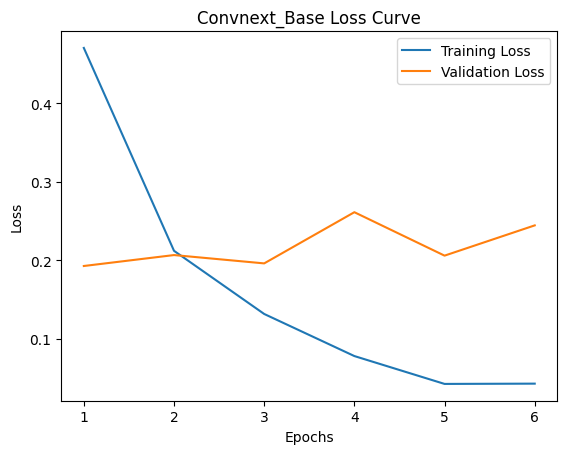

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Convnext_Base Loss Curve')
plt.legend()
#plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Calculate metrics on test set
calculate_metrics(model, test_loader)

Testing: 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]


Precision: 0.9359
Recall: 0.9362
F1 Score: 0.9352


Testing: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


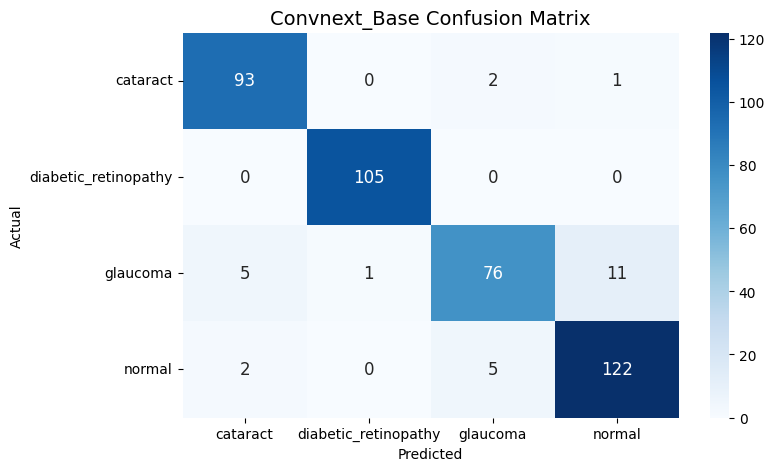

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix with updated figure size and text size
    plt.figure(figsize=(8, 5))  # Adjusted figure size (width=8, height=6)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size": 12}  # Increased text size for annotations
    )
    plt.xlabel('Predicted', fontsize=10)  # Increased font size for x-axis label
    plt.ylabel('Actual', fontsize=10)    # Increased font size for y-axis label
    plt.title('Convnext_Base Confusion Matrix', fontsize=14)  # Increased font size for title
    plt.xticks(rotation=0, fontsize=10)  # Rotate x-axis labels to horizontal (0 degrees)
    plt.yticks(fontsize=10)  # Font size for y-axis tick labels
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, class_names)


In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), "convnext_base.pth")

#ShuffleNet V2

In [ ]:
import torchvision.models as models

# Load pretrained ShuffleNet V2 model
model = models.shufflenet_v2_x1_0(pretrained=True)

num_classes = len(dataset.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 44.6MB/s]


In [ ]:
import time
from tqdm import tqdm
import torch
import torch.nn as nn

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training and validation
num_epochs = 50
train_losses, val_losses = [], []

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5)

# Start timer
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_correct = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_acc = 100.0 * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100.0 * val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# End timer
end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Total Execution Time: {execution_time:.2f} seconds")

Epoch 1/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Train Loss: 1.2765, Train Accuracy: 64.55%
Val Loss: 1.0085, Val Accuracy: 79.12%

Epoch 2/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Train Loss: 0.8592, Train Accuracy: 82.92%
Val Loss: 0.5730, Val Accuracy: 89.21%

Epoch 3/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.70it/s]


Train Loss: 0.5013, Train Accuracy: 90.27%
Val Loss: 0.3743, Val Accuracy: 90.98%

Epoch 4/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Train Loss: 0.3432, Train Accuracy: 91.12%
Val Loss: 0.2820, Val Accuracy: 92.53%

Epoch 5/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Train Loss: 0.2438, Train Accuracy: 94.10%
Val Loss: 0.2469, Val Accuracy: 92.41%

Epoch 6/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Train Loss: 0.1833, Train Accuracy: 95.53%
Val Loss: 0.2521, Val Accuracy: 91.81%

Epoch 7/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.75it/s]


Train Loss: 0.1564, Train Accuracy: 95.83%
Val Loss: 0.2414, Val Accuracy: 91.93%

Epoch 8/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Train Loss: 0.1150, Train Accuracy: 97.66%
Val Loss: 0.2205, Val Accuracy: 92.17%

Epoch 9/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Train Loss: 0.0837, Train Accuracy: 98.41%
Val Loss: 0.2393, Val Accuracy: 92.76%

Epoch 10/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.71it/s]


Train Loss: 0.0781, Train Accuracy: 98.27%
Val Loss: 0.2344, Val Accuracy: 93.24%

Epoch 11/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.52it/s]


Train Loss: 0.0620, Train Accuracy: 98.37%
Val Loss: 0.2500, Val Accuracy: 93.00%

Epoch 12/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Train Loss: 0.0462, Train Accuracy: 98.98%
Val Loss: 0.2309, Val Accuracy: 93.12%

Epoch 13/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.41it/s]

Train Loss: 0.0488, Train Accuracy: 99.02%
Val Loss: 0.2786, Val Accuracy: 91.34%

Early stopping triggered. Stopping training.
Total Execution Time: 520.62 seconds


In [ ]:
# Test model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(f"\nTest Accuracy: {accuracy:.2f}%")

# Evaluate on test set
evaluate_model(model, test_loader)

Testing: 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


Test Accuracy: 91.73%


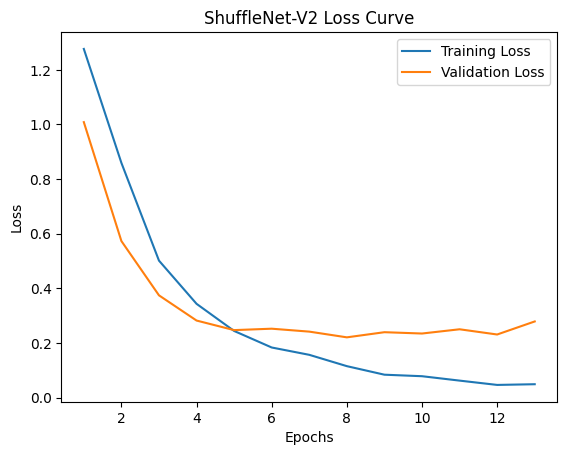

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ShuffleNet-V2 Loss Curve')
plt.legend()
#plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Calculate metrics on test set
calculate_metrics(model, test_loader)

Testing: 100%|██████████| 14/14 [00:04<00:00,  3.32it/s]


Precision: 0.9172
Recall: 0.9173
F1 Score: 0.9161


Testing: 100%|██████████| 14/14 [00:03<00:00,  3.98it/s]


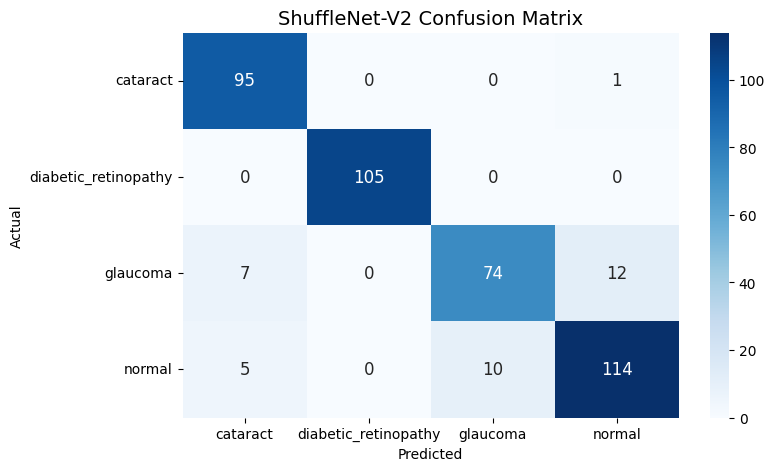

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix with updated figure size and text size
    plt.figure(figsize=(8, 5))  # Adjusted figure size (width=8, height=6)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size": 12}  # Increased text size for annotations
    )
    plt.xlabel('Predicted', fontsize=10)  # Increased font size for x-axis label
    plt.ylabel('Actual', fontsize=10)    # Increased font size for y-axis label
    plt.title('ShuffleNet-V2 Confusion Matrix', fontsize=14)  # Increased font size for title
    plt.xticks(rotation=0, fontsize=10)  # Rotate x-axis labels to horizontal (0 degrees)
    plt.yticks(fontsize=10)  # Font size for y-axis tick labels
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, class_names)

In [ ]:
# Load best model
torch.save(model.state_dict(), "shufflenet-v2.pth")

# **Efficient Net V2**

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained EfficientNetV2 (for example: 'efficientnet_v2_s')
model = models.efficientnet_v2_s(pretrained=True)

# Update the final classifier layer to match your number of classes
num_classes = len(dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move model to GPU if available
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 194MB/s]


In [ ]:
import time
from tqdm import tqdm
import torch
import torch.nn as nn

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training and validation
num_epochs = 50
train_losses, val_losses = [], []

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5)

# Start timer
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_correct = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_acc = 100.0 * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100.0 * val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# End timer
end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Total Execution Time: {execution_time:.2f} seconds")

Epoch 1/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]


Train Loss: 0.5790, Train Accuracy: 80.04%
Val Loss: 0.2301, Val Accuracy: 91.93%

Epoch 2/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]


Train Loss: 0.2042, Train Accuracy: 93.29%
Val Loss: 0.2147, Val Accuracy: 93.00%

Epoch 3/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


Train Loss: 0.1131, Train Accuracy: 96.37%
Val Loss: 0.3030, Val Accuracy: 90.15%

Epoch 4/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.78it/s]


Train Loss: 0.0649, Train Accuracy: 97.93%
Val Loss: 0.2452, Val Accuracy: 93.00%

Epoch 5/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.81it/s]


Train Loss: 0.0536, Train Accuracy: 98.48%
Val Loss: 0.1968, Val Accuracy: 93.71%

Epoch 6/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]


Train Loss: 0.0287, Train Accuracy: 99.15%
Val Loss: 0.2215, Val Accuracy: 94.42%

Epoch 7/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]


Train Loss: 0.0349, Train Accuracy: 98.78%
Val Loss: 0.3548, Val Accuracy: 90.98%

Epoch 8/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]


Train Loss: 0.0363, Train Accuracy: 98.85%
Val Loss: 0.2628, Val Accuracy: 93.48%

Epoch 9/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]


Train Loss: 0.0186, Train Accuracy: 99.39%
Val Loss: 0.2183, Val Accuracy: 94.54%

Epoch 10/50


Validation: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]

Train Loss: 0.0154, Train Accuracy: 99.63%
Val Loss: 0.2530, Val Accuracy: 93.48%

Early stopping triggered. Stopping training.
Total Execution Time: 685.15 seconds


In [ ]:
# Test model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(f"\nTest Accuracy: {accuracy:.2f}%")

# Evaluate on test set
evaluate_model(model, test_loader)

Testing: 100%|██████████| 14/14 [00:04<00:00,  3.15it/s]


Test Accuracy: 93.85%


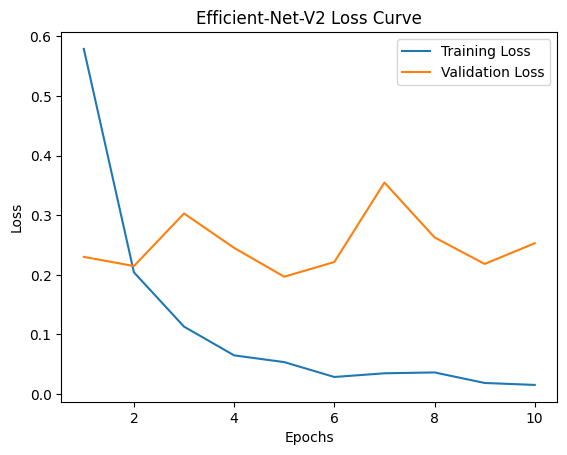

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Efficient-Net-V2 Loss Curve')
plt.legend()
#plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Calculate metrics on test set
calculate_metrics(model, test_loader)

Testing: 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


Precision: 0.9386
Recall: 0.9385
F1 Score: 0.9378


Testing: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


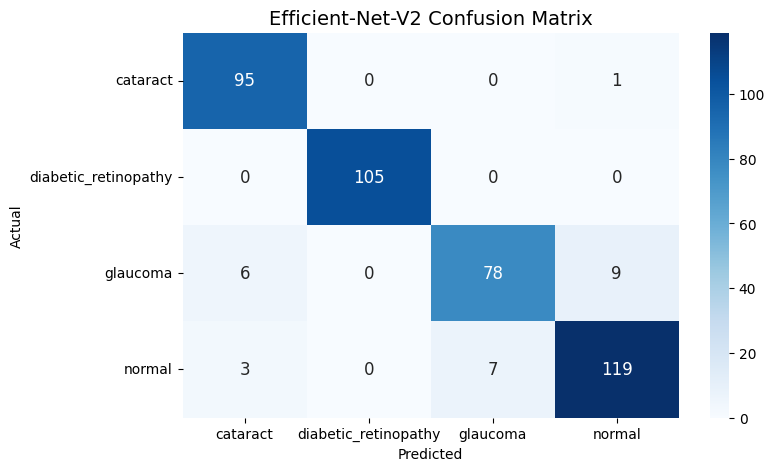

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix with updated figure size and text size
    plt.figure(figsize=(8, 5))  # Adjusted figure size (width=8, height=6)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size": 12}  # Increased text size for annotations
    )
    plt.xlabel('Predicted', fontsize=10)  # Increased font size for x-axis label
    plt.ylabel('Actual', fontsize=10)    # Increased font size for y-axis label
    plt.title('Efficient-Net-V2 Confusion Matrix', fontsize=14)  # Increased font size for title
    plt.xticks(rotation=0, fontsize=10)  # Rotate x-axis labels to horizontal (0 degrees)
    plt.yticks(fontsize=10)  # Font size for y-axis tick labels
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, class_names)

In [ ]:
# Load best model
torch.save(model.state_dict(), "efficient-net-v2.pth")

#MobileNet V3 Large

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained MobileNet V3 Large
model = models.mobilenet_v3_large(pretrained=True)

# Modify the classifier head
num_classes = len(dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# Move to device
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 135MB/s]


In [ ]:
import time
from tqdm import tqdm
import torch
import torch.nn as nn

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training and validation
num_epochs = 50
train_losses, val_losses = [], []

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5)

# Start timer
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_correct = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_acc = 100.0 * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100.0 * val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# End timer
end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Total Execution Time: {execution_time:.2f} seconds")

Epoch 1/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Train Loss: 0.5643, Train Accuracy: 78.82%
Val Loss: 1.2745, Val Accuracy: 45.55%

Epoch 2/50


Validation: 100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Train Loss: 0.2201, Train Accuracy: 91.97%
Val Loss: 0.5654, Val Accuracy: 78.77%

Epoch 3/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Train Loss: 0.1375, Train Accuracy: 94.98%
Val Loss: 0.3232, Val Accuracy: 88.26%

Epoch 4/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Train Loss: 0.0840, Train Accuracy: 96.75%
Val Loss: 0.2395, Val Accuracy: 91.34%

Epoch 5/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Train Loss: 0.0615, Train Accuracy: 98.17%
Val Loss: 0.2832, Val Accuracy: 90.51%

Epoch 6/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Train Loss: 0.0331, Train Accuracy: 98.81%
Val Loss: 0.1826, Val Accuracy: 94.19%

Epoch 7/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Train Loss: 0.0249, Train Accuracy: 99.25%
Val Loss: 0.2220, Val Accuracy: 93.83%

Epoch 8/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Train Loss: 0.0242, Train Accuracy: 99.15%
Val Loss: 0.2677, Val Accuracy: 92.65%

Epoch 9/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Train Loss: 0.0248, Train Accuracy: 99.36%
Val Loss: 0.2139, Val Accuracy: 93.59%

Epoch 10/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Train Loss: 0.0272, Train Accuracy: 99.25%
Val Loss: 0.2487, Val Accuracy: 92.29%

Epoch 11/50


Validation: 100%|██████████| 27/27 [00:08<00:00,  3.31it/s]

Train Loss: 0.0091, Train Accuracy: 99.73%
Val Loss: 0.2802, Val Accuracy: 93.36%

Early stopping triggered. Stopping training.
Total Execution Time: 469.80 seconds


In [ ]:
# Test model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(f"\nTest Accuracy: {accuracy:.2f}%")

# Evaluate on test set
evaluate_model(model, test_loader)

Testing: 100%|██████████| 14/14 [00:03<00:00,  3.80it/s]


Test Accuracy: 93.14%


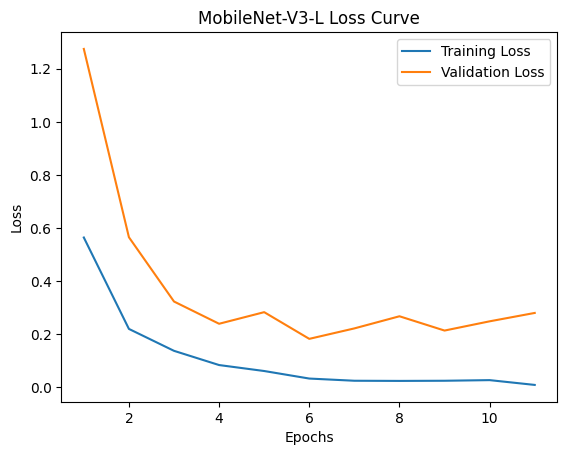

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNet-V3-L Loss Curve')
plt.legend()
#plt.grid(True)
plt.show()



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Calculate metrics on test set
calculate_metrics(model, test_loader)

Testing: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s]


Precision: 0.9327
Recall: 0.9314
F1 Score: 0.9299


Testing: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]


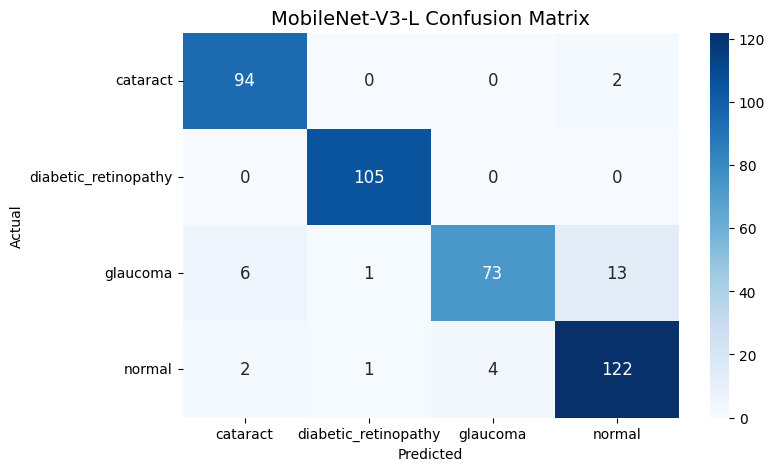

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix with updated figure size and text size
    plt.figure(figsize=(8, 5))  # Adjusted figure size (width=8, height=6)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size": 12}  # Increased text size for annotations
    )
    plt.xlabel('Predicted', fontsize=10)  # Increased font size for x-axis label
    plt.ylabel('Actual', fontsize=10)    # Increased font size for y-axis label
    plt.title('MobileNet-V3-L Confusion Matrix', fontsize=14)  # Increased font size for title
    plt.xticks(rotation=0, fontsize=10)  # Rotate x-axis labels to horizontal (0 degrees)
    plt.yticks(fontsize=10)  # Font size for y-axis tick labels
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, class_names)

In [ ]:
# Load best model
torch.save(model.state_dict(), "mobilenet_v3_l.pth")

# **Grad-CAM for MobileNetV2**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saving 102_left.jpeg to 102_left.jpeg


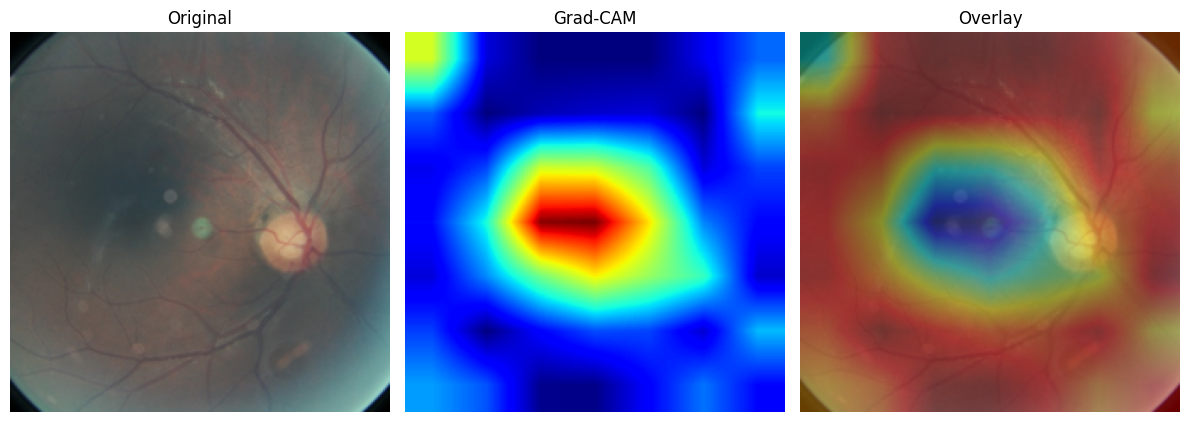

In [ ]:
# Install necessary packages
!pip install -q torch torchvision matplotlib opencv-python

# Imports
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MobileNetV2 (Large)
model = models.mobilenet_v3_large(pretrained=True).to(device)
model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Upload an image
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')

# Preprocess image
input_tensor = transform(img).unsqueeze(0).to(device)

# Grad-CAM hook variables
gradients = []
activations = []

# Hook for gradients
def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Hook for forward activations
def forward_hook(module, input, output):
    activations.append(output)

# Register hooks on the last feature layer
target_layer = model.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1)

# Backward pass
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

# Grad-CAM calculation
grads = gradients[0].detach().cpu().numpy()[0]
acts = activations[0].detach().cpu().numpy()[0]

weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(acts.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam = cam - cam.min()
cam = cam / cam.max()

# Convert original image for overlay
img_np = np.array(img.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = 0.4 * heatmap + 0.6 * img_np

# Show results
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(cam, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(np.uint8(overlay))
plt.axis('off')
plt.tight_layout()
plt.show()


# **Grad-CAM for EfficientNetV2**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saving 102_left.jpeg to 102_left (1).jpeg


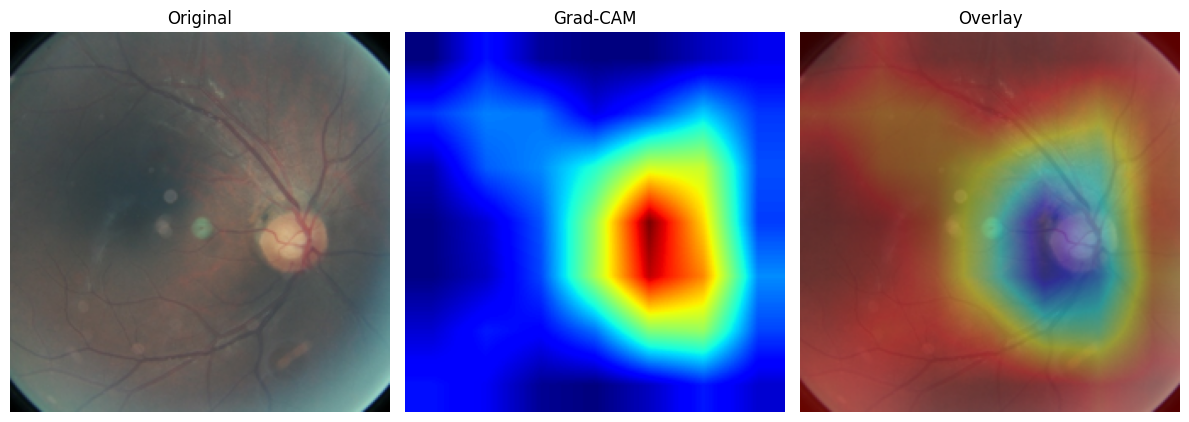

In [ ]:
# Install necessary packages
!pip install -q torch torchvision matplotlib opencv-python

# Imports
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNetV2 (Large)
model = models.efficientnet_v2_s(pretrained=True).to(device)
model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Upload an image
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')

# Preprocess image
input_tensor = transform(img).unsqueeze(0).to(device)

# Grad-CAM hook variables
gradients = []
activations = []

# Hook for gradients
def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Hook for forward activations
def forward_hook(module, input, output):
    activations.append(output)

# Register hooks on the last feature layer
target_layer = model.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1)

# Backward pass
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

# Grad-CAM calculation
grads = gradients[0].detach().cpu().numpy()[0]
acts = activations[0].detach().cpu().numpy()[0]

weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(acts.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam = cam - cam.min()
cam = cam / cam.max()

# Convert original image for overlay
img_np = np.array(img.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = 0.4 * heatmap + 0.6 * img_np

# Show results
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(cam, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(np.uint8(overlay))
plt.axis('off')
plt.tight_layout()
plt.show()


# **Grad-CAM for ShuffleNet**

Saving 102_left.jpeg to 102_left (4).jpeg


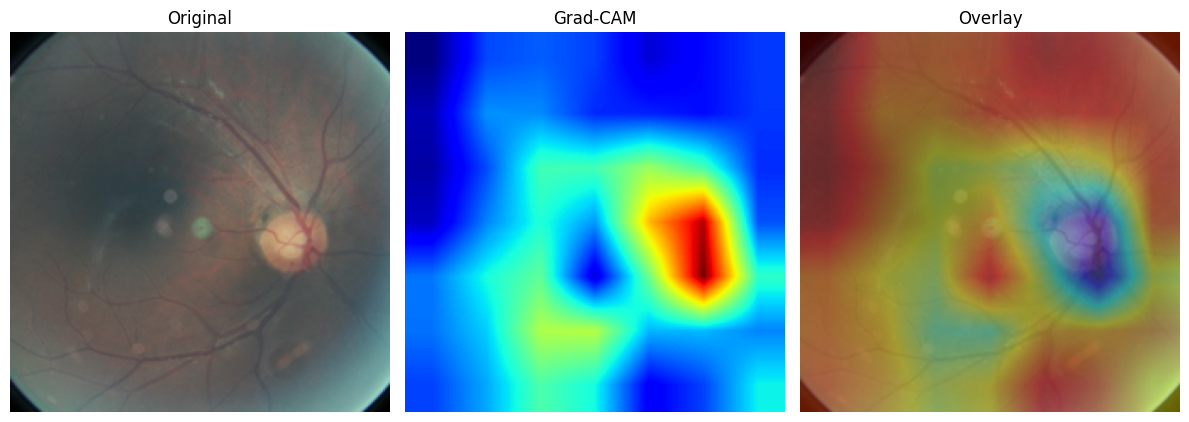

In [ ]:
# Install necessary packages
!pip install -q torch torchvision matplotlib opencv-python

# Imports
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load pretrained ShuffleNet V2 model
model = models.shufflenet_v2_x1_0(pretrained=True).to(device)

model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Upload an image
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')

# Preprocess image
input_tensor = transform(img).unsqueeze(0).to(device)

# Grad-CAM hook variables
gradients = []
activations = []

# Hook for gradients
def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Hook for forward activations
def forward_hook(module, input, output):
    activations.append(output)

# Register hooks on the last feature layer
target_layer = model.conv5
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1)

# Backward pass
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

# Grad-CAM calculation
grads = gradients[0].detach().cpu().numpy()[0]
acts = activations[0].detach().cpu().numpy()[0]

weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(acts.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam = cam - cam.min()
cam = cam / cam.max()

# Convert original image for overlay
img_np = np.array(img.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = 0.4 * heatmap + 0.6 * img_np

# Show results
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(cam, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(np.uint8(overlay))
plt.axis('off')
plt.tight_layout()
plt.show()


# **Grad-CAM for ConvNeXt**

Saving 102_left.jpeg to 102_left (3).jpeg


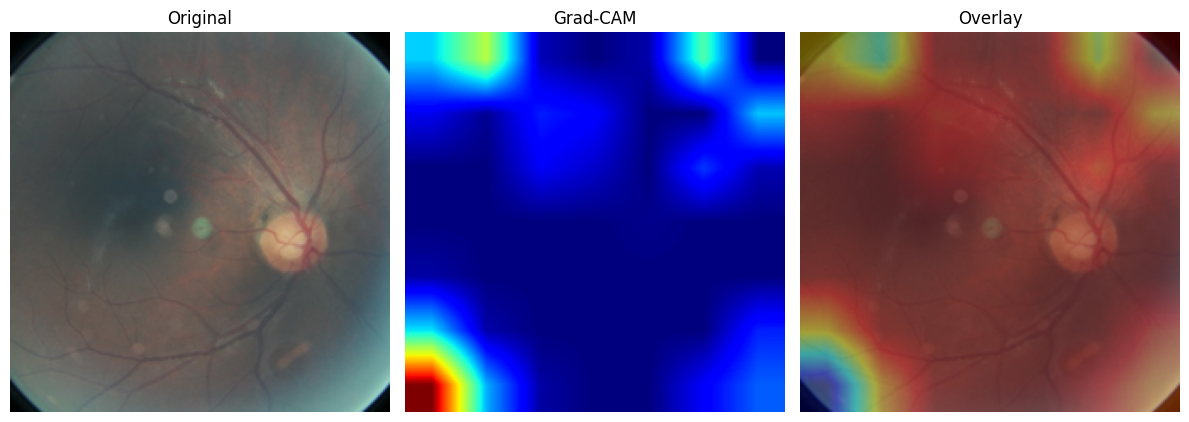

In [ ]:
# Install necessary packages
!pip install -q torch torchvision matplotlib opencv-python

# Imports
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load pretrained ConvNeXt
model = convnext_base(pretrained=True).to(device)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(dataset.classes))
model.to(device)
model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Upload an image
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')

# Preprocess image
input_tensor = transform(img).unsqueeze(0).to(device)

# Grad-CAM hook variables
gradients = []
activations = []

# Hook for gradients
def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Hook for forward activations
def forward_hook(module, input, output):
    activations.append(output)

# Register hooks on the last feature layer
target_layer = model.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1)

# Backward pass
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

# Grad-CAM calculation
grads = gradients[0].detach().cpu().numpy()[0]
acts = activations[0].detach().cpu().numpy()[0]

weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(acts.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam = cam - cam.min()
cam = cam / cam.max()

# Convert original image for overlay
img_np = np.array(img.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = 0.4 * heatmap + 0.6 * img_np

# Show results
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(cam, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(np.uint8(overlay))
plt.axis('off')
plt.tight_layout()
plt.show()
